We are using a dataset which show whether extending credit to a customer will be benficial for the bank or not.

#### 1. Import required libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

#### 2. Import the dataset and inspect it

In [2]:
credit = pd.read_csv('MyCreditData.csv')

In [3]:
credit.head()

,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,gender,profit
0,3,18,0,2,1049,4,2,2,2,3,...,21,1,0,0,1,0,0,0,female,242
1,3,9,0,5,2799,4,0,1,2,0,...,36,1,0,1,1,1,0,0,male,596
2,0,12,4,8,841,0,1,1,2,3,...,23,1,0,0,3,0,0,0,female,25
3,3,12,0,5,2122,4,0,0,2,0,...,39,1,0,1,3,1,0,1,male,568
4,3,12,0,5,2171,4,0,2,2,3,...,38,0,2,1,3,0,0,1,male,782


In [4]:
#check the basic info of the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account         1000 non-null   int64 
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   int64 
 3   purpose                  1000 non-null   int64 
 4   amount                   1000 non-null   int64 
 5   savings_account          1000 non-null   int64 
 6   employment_duration      1000 non-null   int64 
 7   installment_rate         1000 non-null   int64 
 8   other_debtors            1000 non-null   int64 
 9   present_residence        1000 non-null   int64 
 10  property                 1000 non-null   int64 
 11  age                      1000 non-null   int64 
 12  other_installment_plans  1000 non-null   int64 
 13  housing                  1000 non-null   int64 
 14  number_credits           1000 non-null   

In [5]:
#check for the missing values
credit.isnull().sum()

checking_account           0
duration                   0
credit_history             0
purpose                    0
amount                     0
savings_account            0
employment_duration        0
installment_rate           0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
gender                     0
profit                     0
dtype: int64

In [8]:
numerical_columns = ['duration', 'amount', 'age', 'profit']

for column in credit.columns:
    if column not in numerical_columns:
        credit[column] = pd.Categorical(credit[column])

#### 3. Data Preparation for classification

In [9]:
#create is_profitable column usign the profit column 
credit['is_profitable'] = np.where(credit['profit'] > 0, 1, 0)

In [10]:
X = credit.drop(columns = ['profit', 'is_profitable'])
y = credit['is_profitable']

In [11]:
# Use dummy variables for categorical variables
X = pd.get_dummies(X, drop_first = False)

In [12]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [14]:
### Applying Decision Tree Classifier to the data
dec_tree = DecisionTreeClassifier(random_state = 42, max_depth = 10)
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

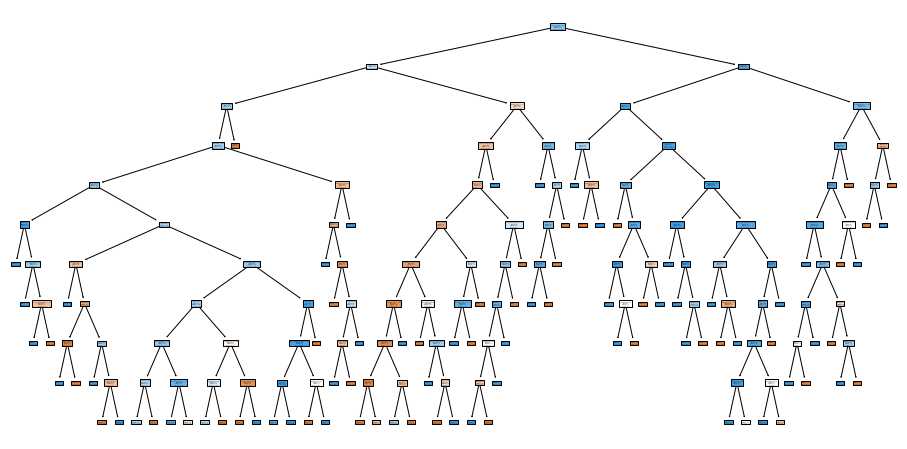

In [15]:
fig = plt.figure(figsize = (16, 8))
fig = tree.plot_tree(dec_tree, feature_names = X.columns, filled = True)

In [16]:
# Print the number of leaves and the depth of the tree
print('Number of leaves =', dec_tree.get_n_leaves())
print('Tree depth =', dec_tree.get_depth())

Number of leaves = 89
Tree depth = 10


In [17]:
y_train_pred = dec_tree.predict(X_train)

y_val_pred = dec_tree.predict(X_val)

In [18]:
# Print the accuracy scores
print(f'Accuracy score on the training dataset: {round(accuracy_score(y_train_pred, y_train), 3)}')
print(f'Accuracy score on the validation dataset: {round(accuracy_score(y_val_pred, y_val), 3)}')

Accuracy score on the training dataset: 0.916
Accuracy score on the validation dataset: 0.697


**Observation:** The accuracy is much higher on training data as compared to validation data which confirms the case of overfitting.

### Pruning the tree to reduce Overfitting

We prune the tree using a complexity parameter called `ccp_alpha`, in the `DecisionTreeClassifier()` method. By varying the value of `ccp_alpha` we get a range of trees of different complexity. Smaller values of `ccp_alpha` result in larger trees, while larger values of `ccp_alpha` result in smaller trees. Higher values of the complexity parameter raise the threshold for introducing a split, based on the contribution of the split to lowering misclassification rates.

The `DecisionTreeClassifier()` method in scikit-learn has an algorithm called `cost_complexity_pruning_path()` which finds all candidates for `ccp_alpha`. We then test each `ccp_alpha` value to test how well the resulting tree does on the validation data, finding an optimal value for the complexity parameter `ccp_alpha`, and the minimum error tree!

In [19]:
# Calculate and print the values of alpha
path = dec_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00026498 0.0007215  0.00094424 0.00095238 0.0012987
 0.00130149 0.00130952 0.00137143 0.00142857 0.00151927 0.001671
 0.00171429 0.00171429 0.00178932 0.00181818 0.00190476 0.00190476
 0.00210419 0.00214286 0.00217687 0.00218254 0.00228445 0.00230159
 0.00238095 0.00244716 0.0025     0.00269841 0.00285714 0.00293575
 0.00319529 0.00323676 0.00330834 0.00333791 0.0033758  0.00337719
 0.0034026  0.0034211  0.00343543 0.00348239 0.00367118 0.00409281
 0.00420075 0.00442285 0.00480159 0.00520552 0.00583696 0.00740969
 0.00763798 0.00809014 0.01117928 0.0436274 ]


In [20]:
# We will create a decision tree model for each alpha and store the models in a list
clfs = []

for ccp_alpha in ccp_alphas:

    # Train a model with a value from the list of ccp_alphas
    curr_clf = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    curr_clf.fit(X_train, y_train)

    # Add the model to the list of models
    clfs.append(curr_clf)

In [21]:
# Create an empty list to store the accuracy values for the training and validation datasets
train_acc = []
val_acc = []

# Iterate over the list of models
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_val_pred = c.predict(X_val)

    # Append the accuracy values for the training and validation datasets to our lists
    train_acc.append(accuracy_score(y_train_pred, y_train))
    val_acc.append(accuracy_score(y_val_pred, y_val))

In [22]:
# Find the value of ccp_alpha for which the validation accuracy is the highest
best_ccp_alpha = ccp_alphas[val_acc.index(max(val_acc))]
print('Best CCP alpha: ', best_ccp_alpha)

Best CCP alpha:  0.004801587301587302


In [23]:
# Train a Decision tree with the best ccp_alpha value
best_tree_clf = tree.DecisionTreeClassifier(random_state = 0, ccp_alpha = best_ccp_alpha)
best_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.004801587301587302, random_state=0)

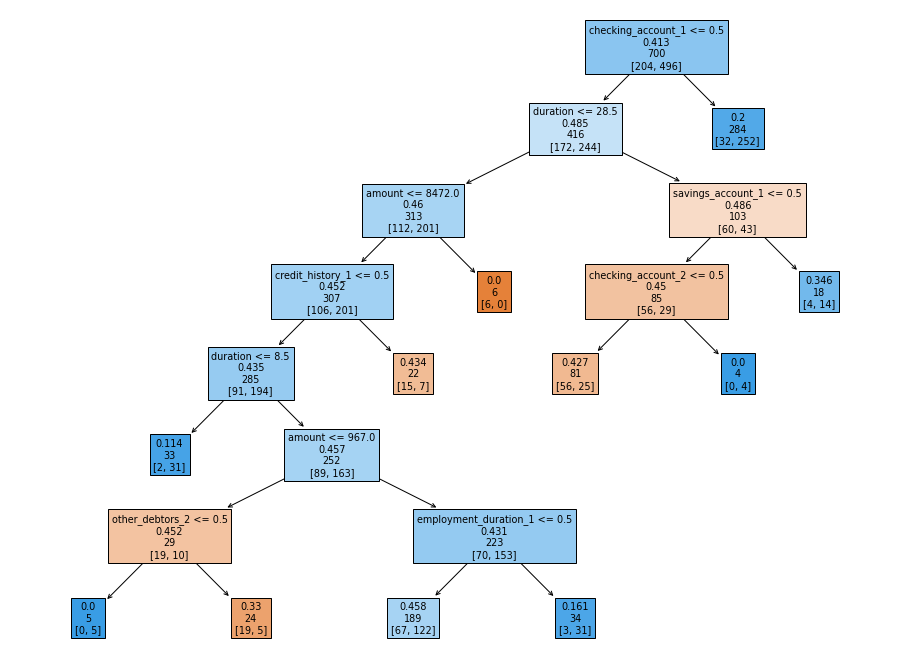

In [24]:
# Visualize the decision tree
fig = plt.figure(figsize = (16, 12))
fig = tree.plot_tree(best_tree_clf, feature_names = X.columns, filled = True, label = None)

In [25]:
# Print the number of leaves and the depth of the tree
print('Number of leaves =', best_tree_clf.get_n_leaves())
print('Tree depth =', best_tree_clf.get_depth())

Number of leaves = 11
Tree depth = 7


In [26]:
# Perform prediction on the training and validation datasets
y_train_pred = best_tree_clf.predict(X_train)
y_val_pred = best_tree_clf.predict(X_val)

In [27]:
# Print the accuracy scores
print(f'Accuracy score on the training dataset: {round(accuracy_score(y_train_pred, y_train), 3)}')
print(f'Accuracy score on the validation dataset: {round(accuracy_score(y_val_pred, y_val), 3)}')

Accuracy score on the training dataset: 0.793
Accuracy score on the validation dataset: 0.727


In [28]:
# Print the other performance measures
print('Performance measures on the validation set\n')
print('Accuracy Score: %.3f' % accuracy_score(y_val, y_val_pred))
print('F1 Score: %.3f' % f1_score(y_val, y_val_pred))
print('Sensitivity (recall of positive class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 1))
print('Specificty (recall of negative class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 0))

Performance measures on the validation set

Accuracy Score: 0.727
F1 Score: 0.818
Sensitivity (recall of positive class): 0.876
Specificty (recall of negative class): 0.378


### Pruning the tree using maximum depth

In [29]:
dec_tree_new = DecisionTreeClassifier(random_state = 42)

In [31]:
# Define the range of the max_depth parameter
param_grid = {'max_depth': np.arange(2, 26)} # Parameter range

# Perform grid search
grid = GridSearchCV(dec_tree_new, param_grid, cv = 5, scoring = 'accuracy', return_train_score = False, verbose = 1)
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [32]:
# Print the optimal value of max_depth
print('The optimal value of max_depth is', grid_search.best_params_['max_depth'])

The optimal value of max_depth is 13


In [33]:
# Train a tree using the optimal max_depth
best_tree_new = DecisionTreeClassifier(random_state = 0, max_depth = grid_search.best_params_['max_depth'])
best_tree_new = best_tree_new.fit(X_train, y_train)

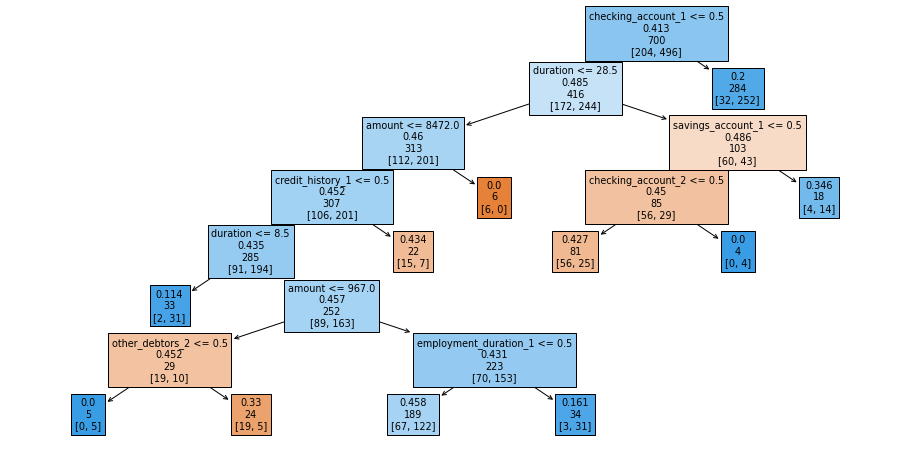

In [34]:
# Visualize the decision tree
fig = plt.figure(figsize = (16, 8))
fig = tree.plot_tree(best_tree_clf, feature_names = X.columns, filled = True, label = None)

In [35]:
# Print the number of leaves and the depth of the tree
print('Number of leaves =', best_tree_new.get_n_leaves())
print('Tree depth =', best_tree_new.get_depth())

Number of leaves = 113
Tree depth = 13


In [36]:
# Perform prediction on the training and validation datasets
y_train_pred = best_tree_new.predict(X_train)
y_val_pred = best_tree_new.predict(X_val)

In [37]:
# Print the accuracy scores
print(f'Accuracy score on the training dataset: {round(accuracy_score(y_train_pred, y_train), 3)}')
print(f'Accuracy score on the validation dataset: {round(accuracy_score(y_val_pred, y_val), 3)}')

Accuracy score on the training dataset: 0.954
Accuracy score on the validation dataset: 0.667


In [38]:
# Print the other performance measures
print('Performance measures on the validation set\n')
print('Accuracy Score: %.3f' % accuracy_score(y_val, y_val_pred))
print('F1 Score: %.3f' % f1_score(y_val, y_val_pred))
print('Sensitivity (recall of positive class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 1))
print('Specificty (recall of negative class): %.3f' % recall_score(y_val, y_val_pred, pos_label = 0))

Performance measures on the validation set

Accuracy Score: 0.667
F1 Score: 0.769
Sensitivity (recall of positive class): 0.790
Specificty (recall of negative class): 0.378
